In [1]:
import numpy as np
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models import MOSFETModel
from src.extraction import ModelExtractor
from src.visualization import *

from scipy.constants import k as k_B, e as q_e
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import plotly.graph_objects as go

## Single Curve MOSFET Fit Demo

For single curve MOSFET I-V data, we can extract the threshold voltage and transconductance parameter of the MOSFET device from a single transfer characteristic ($I_{ds}$ vs $V_{gs}$) with a fixed drain voltage. The fitted vs original data graphs are shown in both linear and semi-log scales to ensure accuarcy in both the ON-state and subthreshold regions.

True params: {'V_th': 0.67, 'k_n': 0.0005, 'lam': 0.02, 'V_ds': 1.0}
Fitted params: {'V_th': 0.6702221826934861, 'k_n': 0.0004989201744563989, 'lam': 0.017489313724997665, 'V_ds': 1.0}
RMS err: 0.021148567586810673


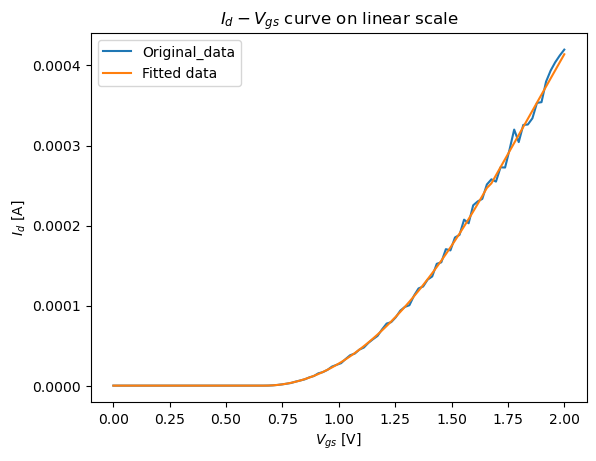

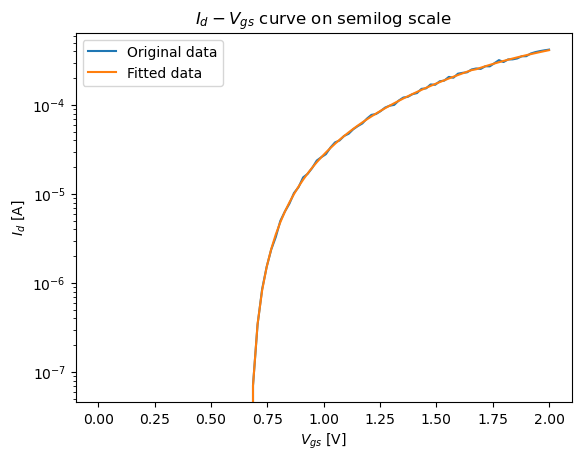

In [2]:
model = MOSFETModel()
extractor = ModelExtractor(model)

true_params = {
    'V_th': 0.67,
    'k_n': 5e-4,
    'lam': 0.02,
    'V_ds': 1.0
}

V_gs = np.linspace(0, 2, 100)
I_true = model.compute_current(V_gs, true_params)

np.random.seed(67)
I_noise = I_true * (1 + np.random.normal(0, 0.03, size=I_true.shape))

report = extractor.mosfet_fit(V_gs, I_noise, V_ds=true_params['V_ds'])
fit = report['parameters']

print("True params:", true_params)
print("Fitted params:", fit)
print("RMS err:", report['rms_err'])

plot_mosfet_fit(V_gs, I_noise, model, fit, None, 'linear')
plot_mosfet_fit(V_gs, I_noise, model, fit, None, 'log')


## Multi-Curve MOSFET Fit Demo

To accurately extract the channel length modulation parameter, you need to use multiple output characteristic curves ($I_{ds}$ vs $V_{ds}$) at different gate-to-source voltages simultaneously. In the saturation region ($V_{ds} > V_{gs} - V_{th}$), the current is not linear and instead increases slightly as $V_{ds}$ increases. This is modeled by the chanel length modulation parameter, $\lambda$:

$$ I_d \propto (1 + \lambda V_{ds}) $$

By using multiple output characteristic curves, the threshold voltage and transconductance are consistent across all operating points, which allows us to find the global value of $\lambda$.

True params: {'V_th': 0.67, 'k_n': 0.0005, 'lam': 0.02, 'V_ds': 1.0}
Fitted params: {'V_th': 0.6699439149764755, 'k_n': 0.0004932998839389962, 'lam': 0.02787243998602007}
RMS err: 0.030602835862201184


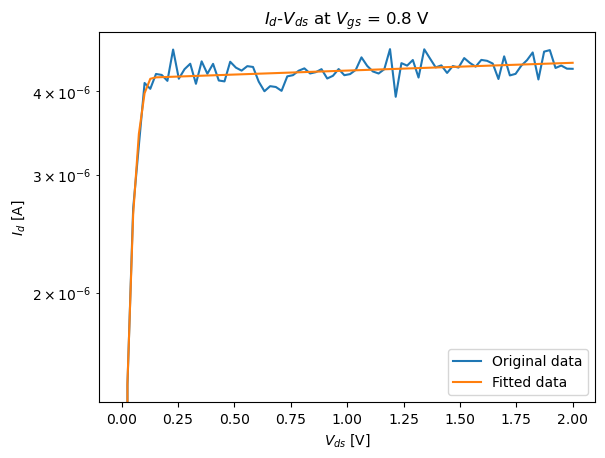

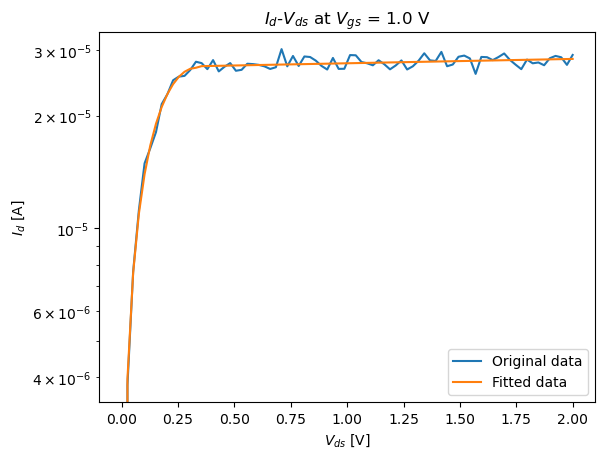

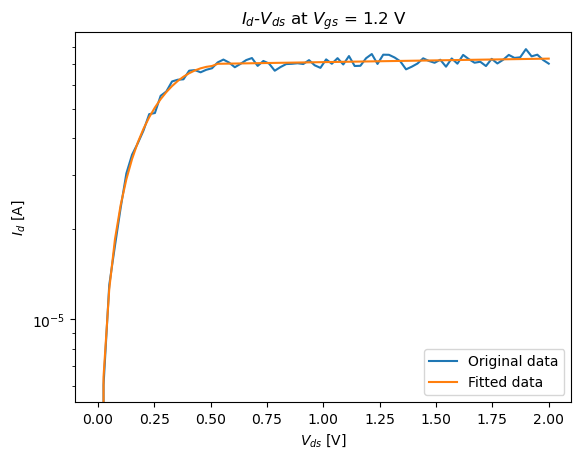

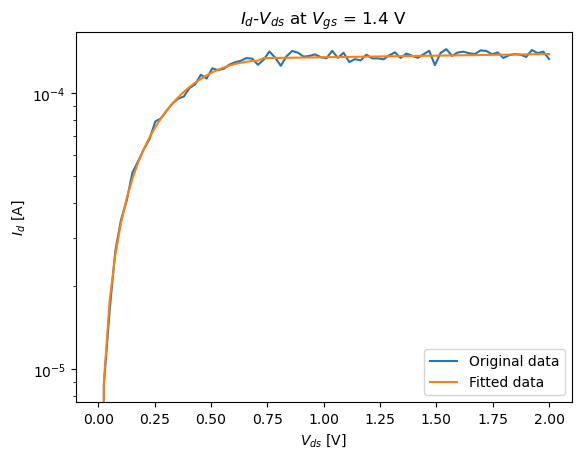

In [3]:
Vds_sweep = np.linspace(0, 2, 80)
Vgs_sweep = [0.8, 1.0, 1.2, 1.4]
datasets = []

np.random.seed(12)
for vgs in Vgs_sweep:
    params = {
        'V_th': true_params['V_th'],
        'k_n': true_params['k_n'],
        'lam': true_params['lam'],
        'V_ds': 0.0
    }
    
    vgs_array = np.full_like(Vds_sweep, vgs)
    I_true = model.compute_current(vgs_array, {**params, 'V_ds': Vds_sweep})
    I_data = I_true * (1 + np.random.normal(0, 0.03, size=I_true.shape))
    datasets.append((Vds_sweep, I_data, vgs))
    
report = extractor.multi_mosfet_fit(datasets)
fit = report['parameters']

print("True params:", true_params)
print("Fitted params:", fit)
print("RMS err:", report['rms_err'])

for Vds, I_data, vgs in datasets:
    vgs_array = np.full_like(Vds, vgs)
    fitted_params = {
        'V_th': fit['V_th'],
        'k_n': fit['k_n'],
        'lam': fit['lam'],
        'vgs_array': vgs_array
    }
    
    plot_mosfet_multi(Vds, I_data, model, fitted_params, V_gs_label=vgs)

## Interactive MOSFET Visualization

The physical operation of the extracted MOSFET model can be visualized by adjusting the gate-to-source and drain-to-source voltage using sliders. A cross-section of a typical MOSFET is drawn and, based on the values of the sliders and the parameters of the device, the channel will alternate between cutoff, saturation, and triode/linear regions.

In [4]:
params = report['parameters']

@interact(
    vgs=FloatSlider(min=0, max=5, step=0.1, value=1.0, description='$V_{gs} [V]'),
    vds=FloatSlider(min=0, max=5, step=0.1, value=0.5, description='$V_{ds} [V]')
)

def view_channel(vgs, vds):
    fig, ax = plt.subplots(figsize=(6, 4))
    draw_mosfet_cross(ax, params, vgs, vds)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='$V_{gs} [V]', max=5.0), FloatSlider(value=0.5, descr…

## 3D Characteristic Surface

A 3D plot can ge generated to get a full picture of the relationship between the drain current, the gate-to-source voltage, and the drain-to-source voltage of the extracted MOSFET model over its entire operating range. Thanks to plotly, the 3D plot is interactive.

In [5]:
fig = plot_3d_fet_surface(model, report['parameters'], 5, 5)
fig.show()

<Figure size 1000x700 with 0 Axes>